# Imports and utility functions

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import pandas as pd
import gc, os
import seaborn as sns
import tifffile
import cv2
import xarray as xr
import xml.etree.ElementTree as ET
import tpae.data.ingest as ti

markers = ['DAPI', 'CLIC5', 'CD34', 'HLADR', 'CD3', 'CD90', 'CD68', 'AF']

k = 5
repname = f'pca_k={k}_harmony'

datadir = f'../BHAM-data/10u'
rawpixelsdir = f'{datadir}/../_qptiff/'
downsampledpixelsdir = f'{datadir}/counts'
normedpixelsdir = f'{datadir}/normalized'
masksdir = f'{datadir}/masks'
processeddir = f'{datadir}/{repname}'

os.makedirs(downsampledpixelsdir, exist_ok=True)
os.makedirs(normedpixelsdir, exist_ok=True)
os.makedirs(masksdir, exist_ok=True)
os.makedirs(processeddir, exist_ok=True)

sids = [f.split('/')[-1].split('.qptiff')[0]
        for f in glob.glob(f'{rawpixelsdir}/*.qptiff')]

# downsample original images

In [ ]:
orig_pixel_size = 0.5
downsample_factor = 20 # we want pixels of size 20x0.5u = 10u

In [ ]:
for sid in sids:
    f = f'{rawpixelsdir}/{sid}.qptiff'
    print('reading', f'../BHAM-data/_qptiff/*.qptiff'')
    sample = np.ascontiguousarray(tifffile.TiffFile(f).series[0].asarray().transpose(1,2,0))
    print('sid:', sid, sample.shape)

    sample = ti.hiresarray_to_downsampledxarray(sample, sid, downsample_factor, orig_pixel_size, markers)
    sample.to_netcdf(f'{downsampledpixelsdir}/{sid}.nc', encoding={sample.name: ti.compression}, engine="netcdf4")
    
    gc.collect()

# create masks and normalize

reading 300-0145_Scan1
44030 of 1990656 (2%) pixels are non-empty


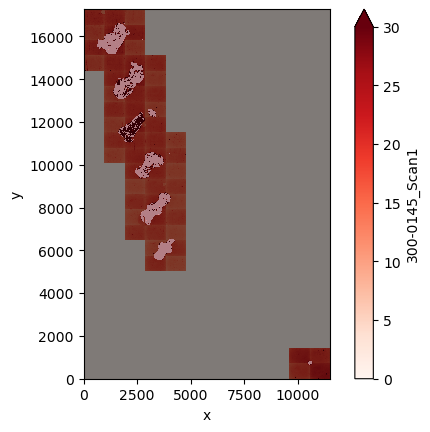

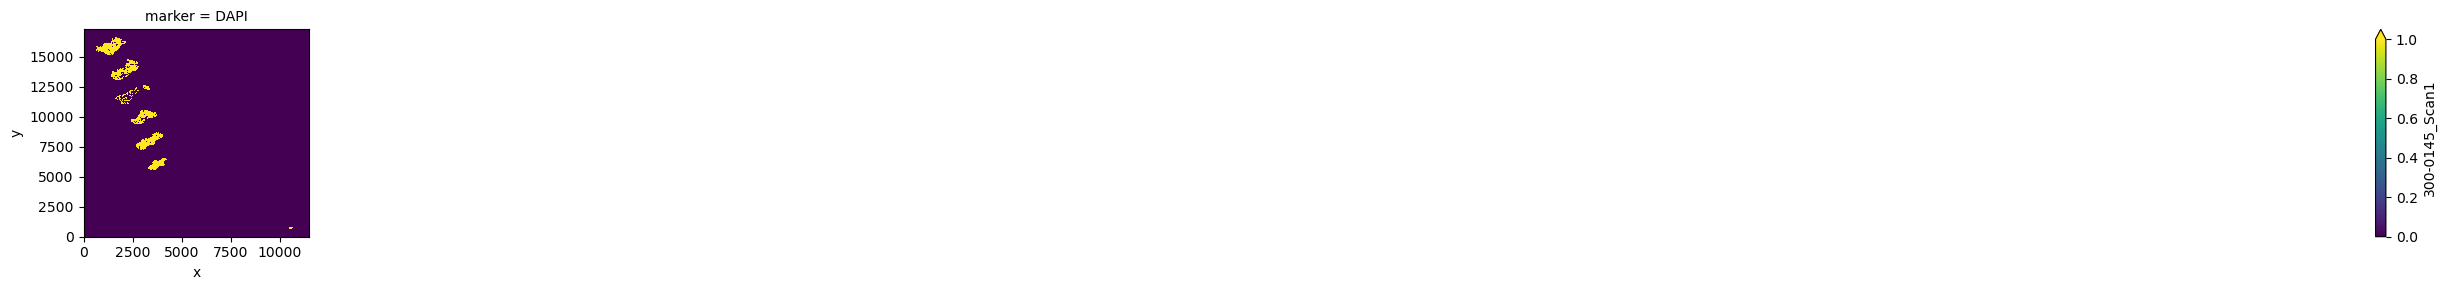

reading 300-2665_Scan1
65901 of 4596480 (1%) pixels are non-empty


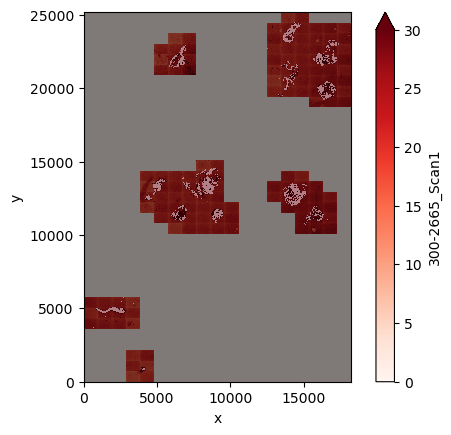

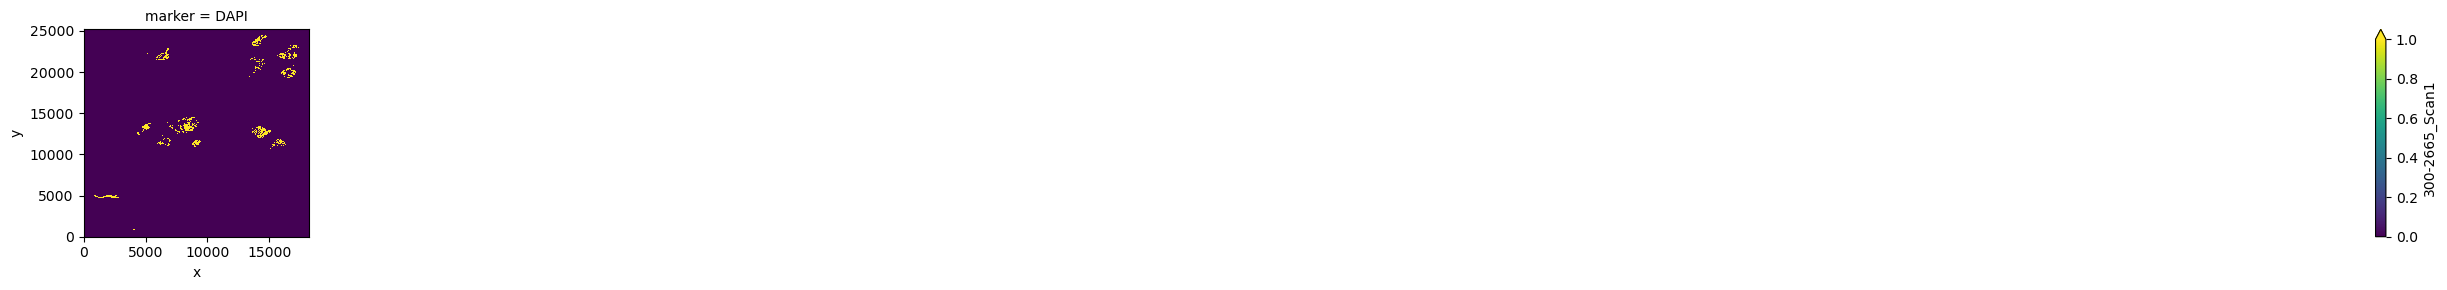

reading 300-0309_Scan3
47555 of 5370624 (1%) pixels are non-empty


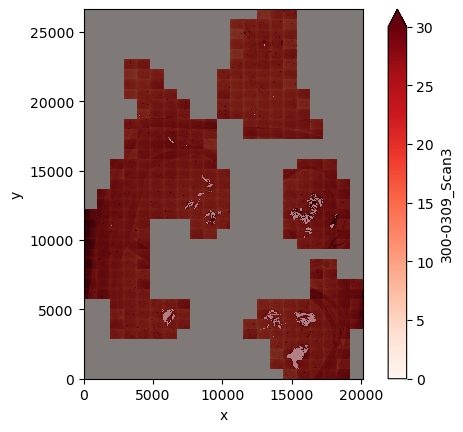

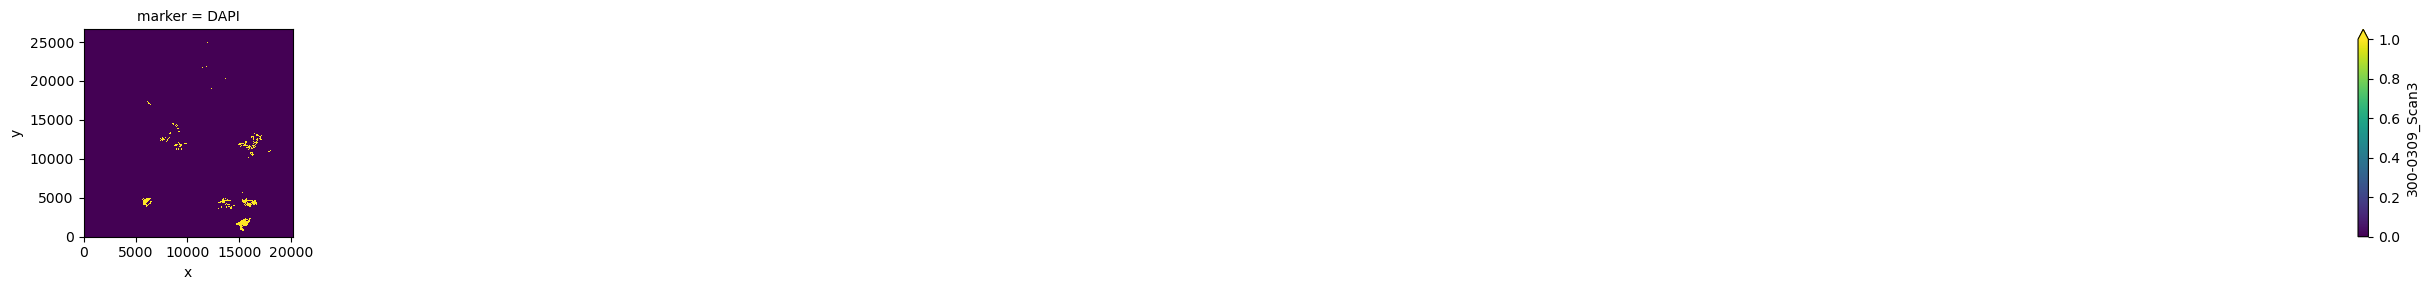

reading 300-0143_Scan1
38481 of 608256 (6%) pixels are non-empty


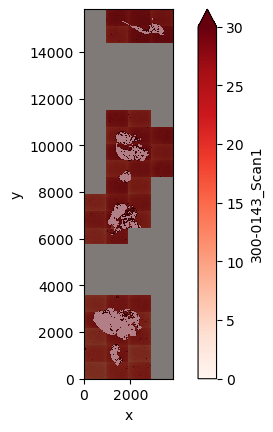

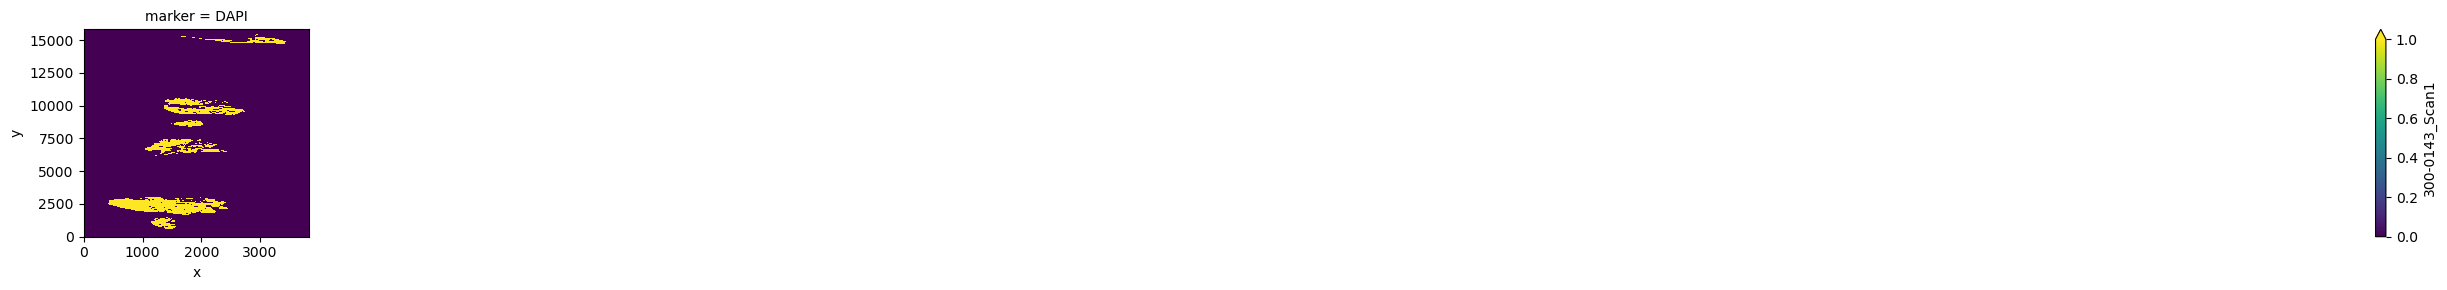

reading 300-0309_Scan1
8845 of 27648 (32%) pixels are non-empty


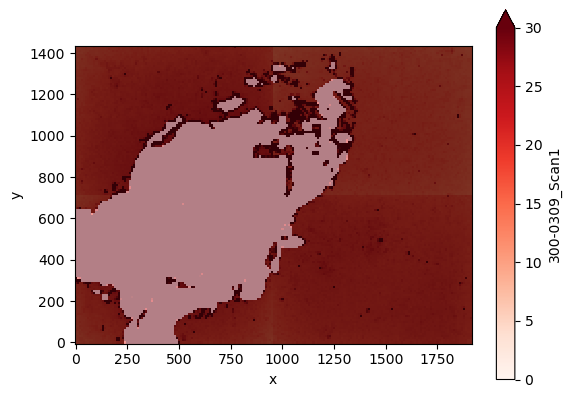

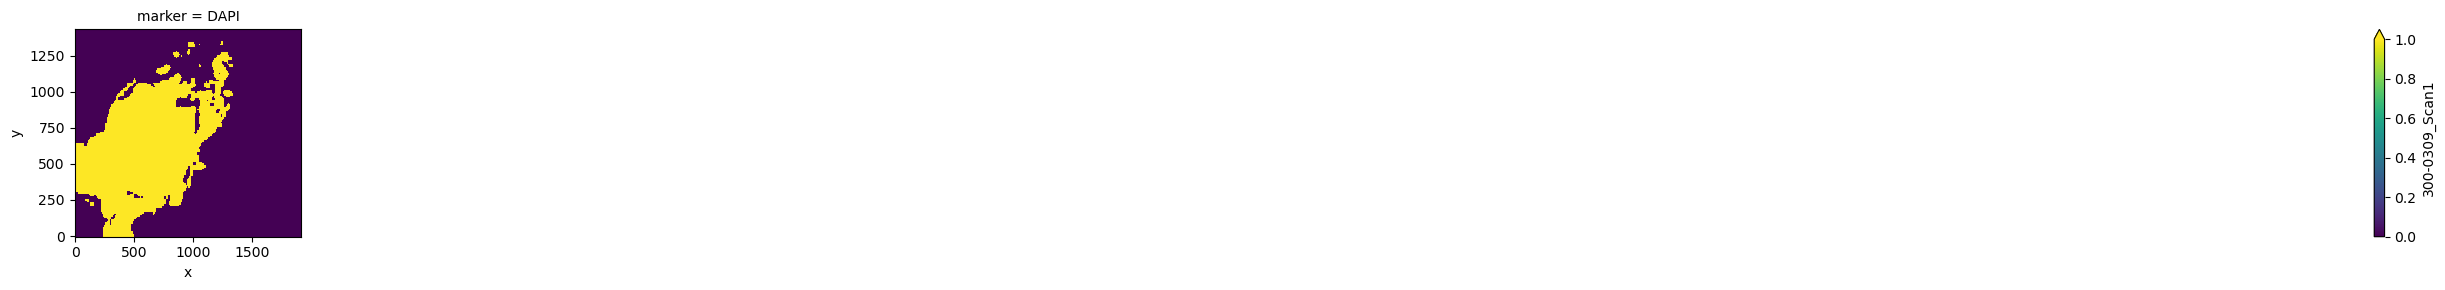

reading 300-1879_Scan1
230712 of 3151872 (7%) pixels are non-empty


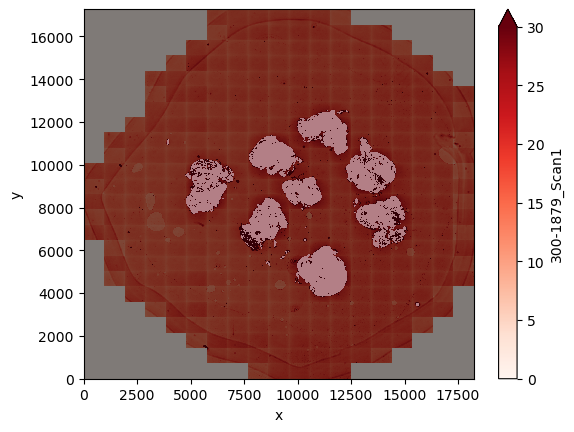

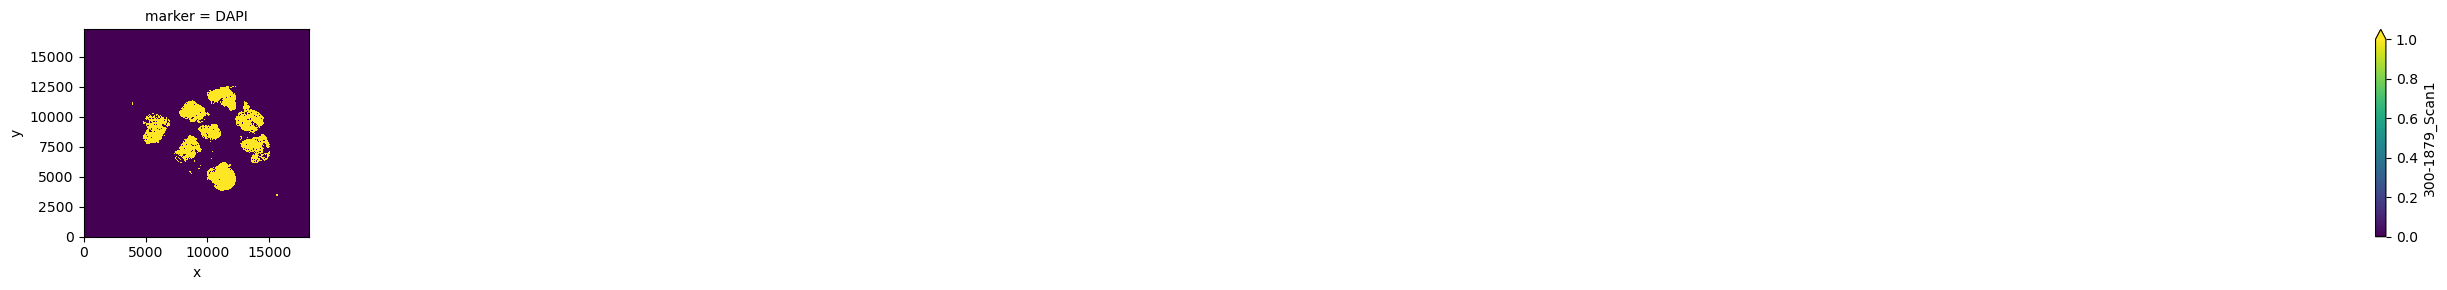

reading 300-1934_Scan3
54290 of 5474304 (1%) pixels are non-empty


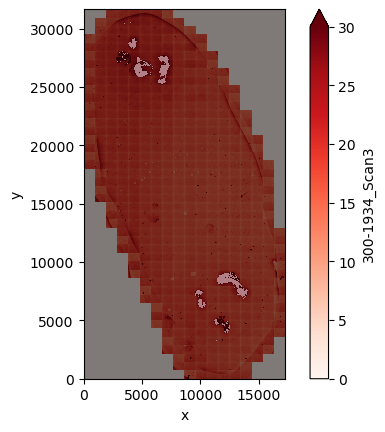

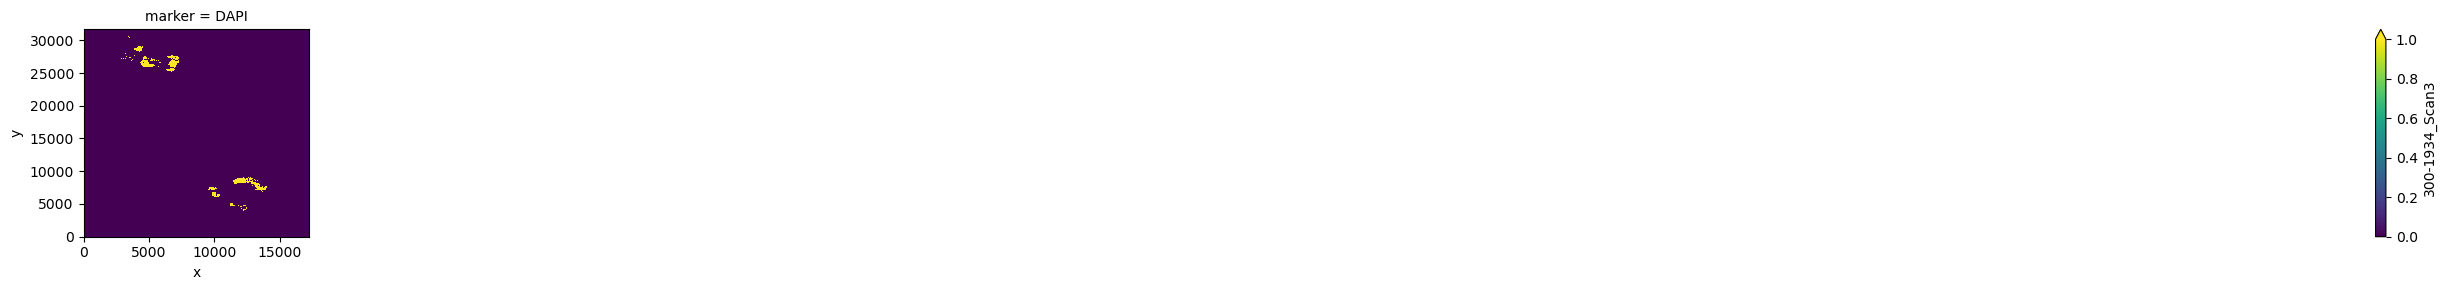

reading 300-0502_Scan1
98711 of 2495232 (4%) pixels are non-empty


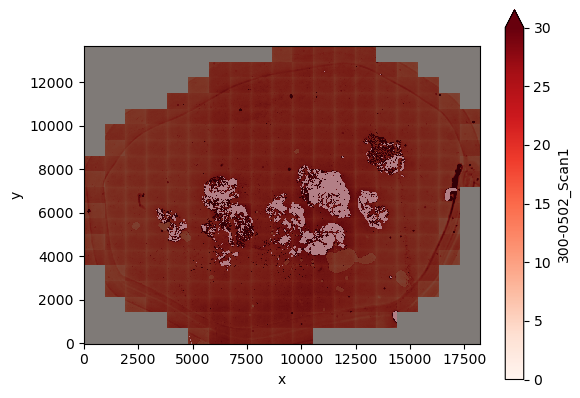

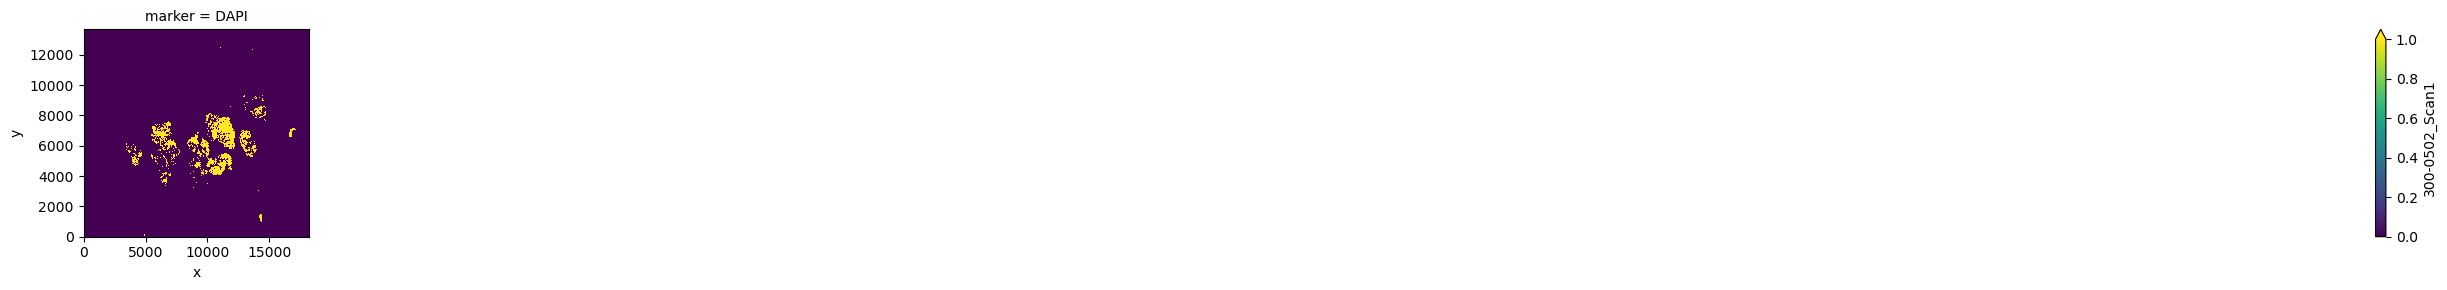

reading 300-0251_Scan1
1042 of 138240 (1%) pixels are non-empty


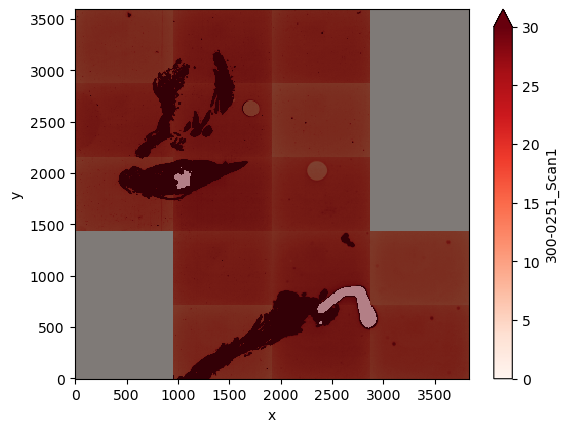

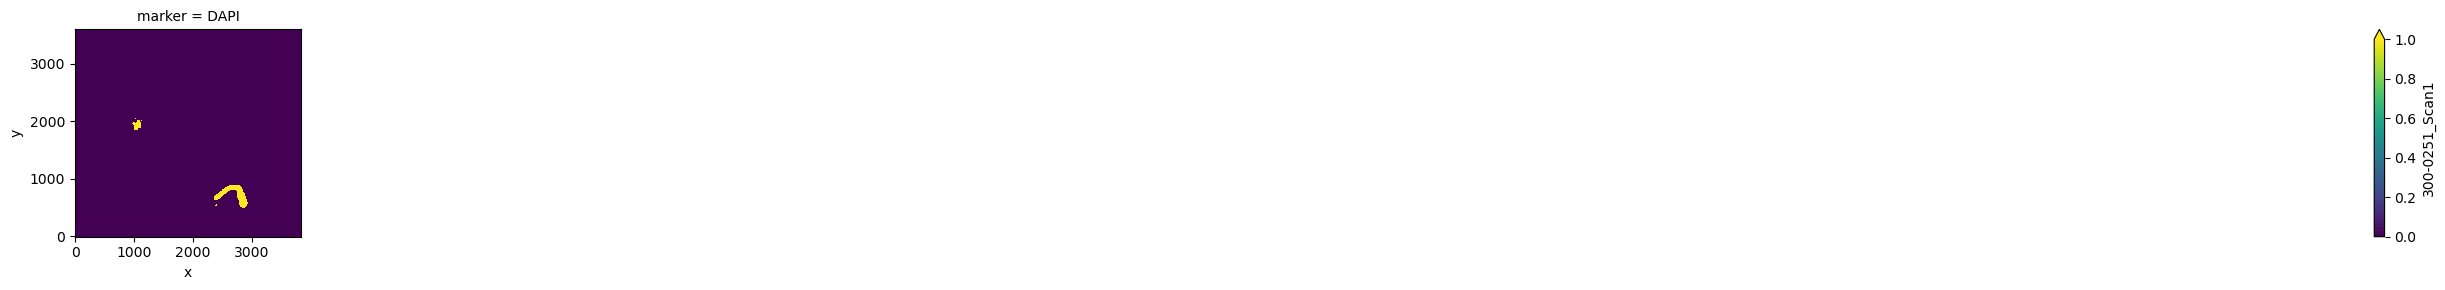

reading 300-0251Repeat_Scan1
74639 of 2985984 (2%) pixels are non-empty


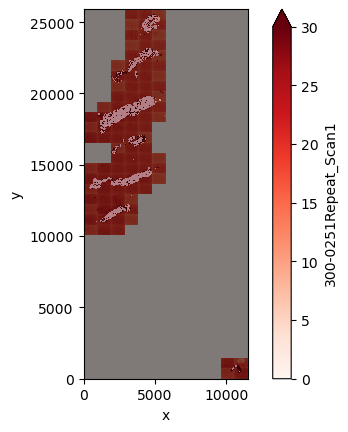

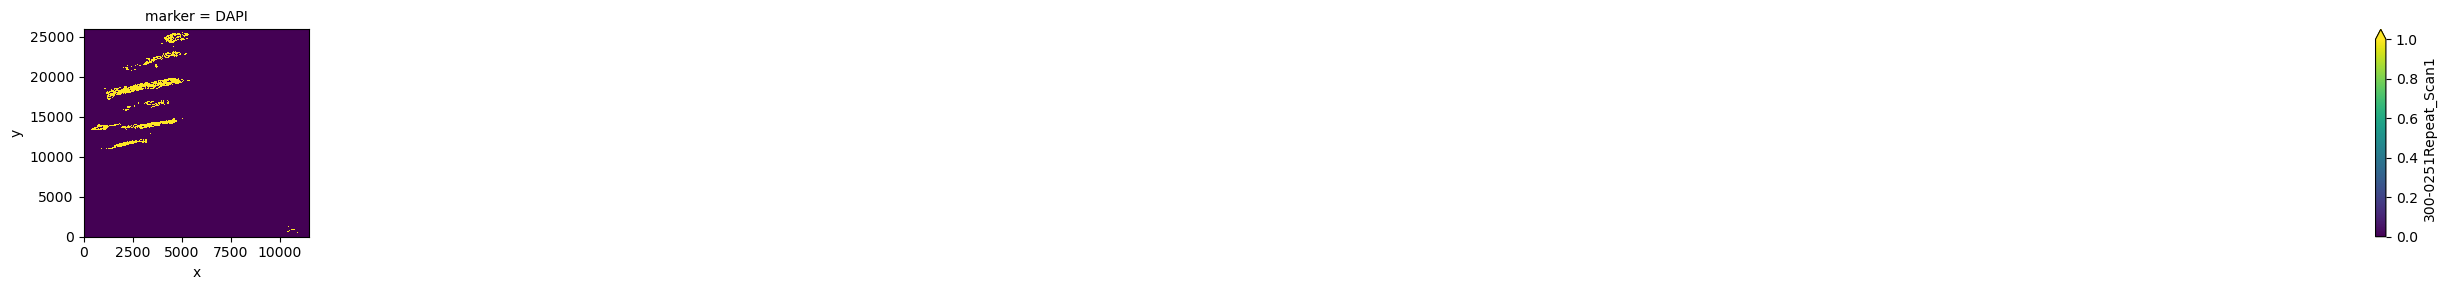

reading 300-1933_Scan1
64505 of 4029696 (2%) pixels are non-empty


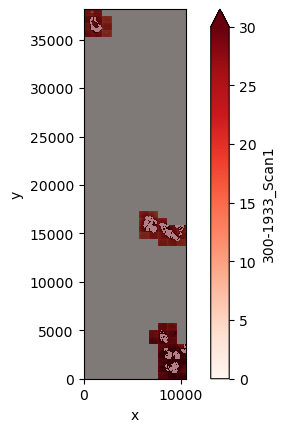

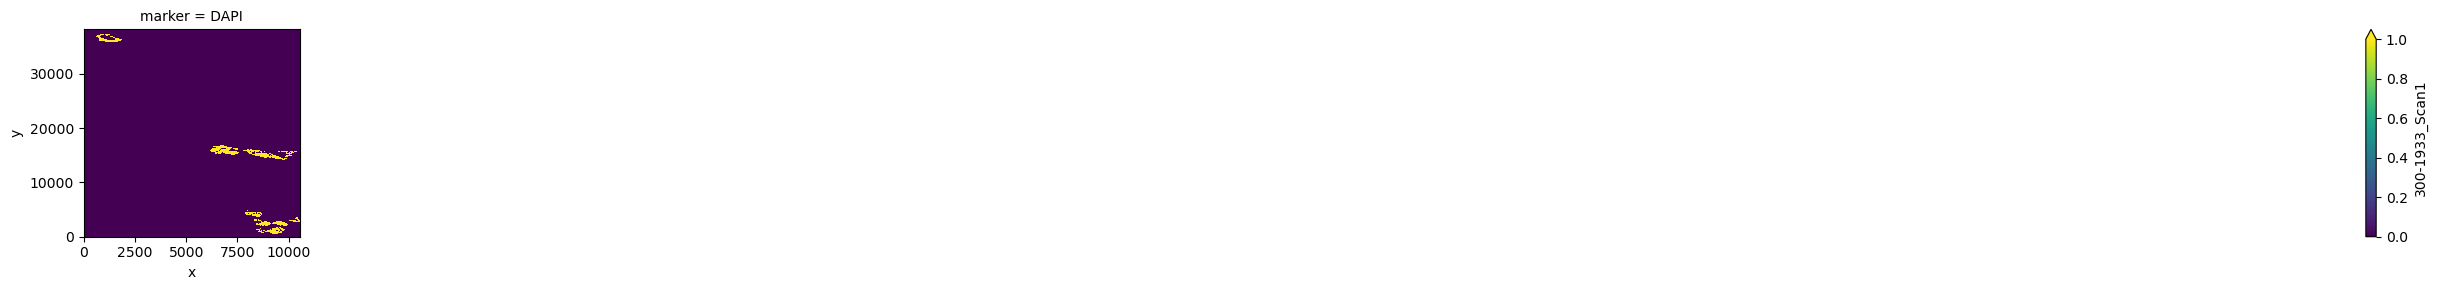

reading 300-0302_Scan1
138048 of 1327104 (10%) pixels are non-empty


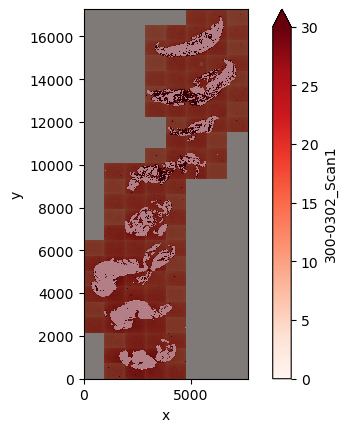

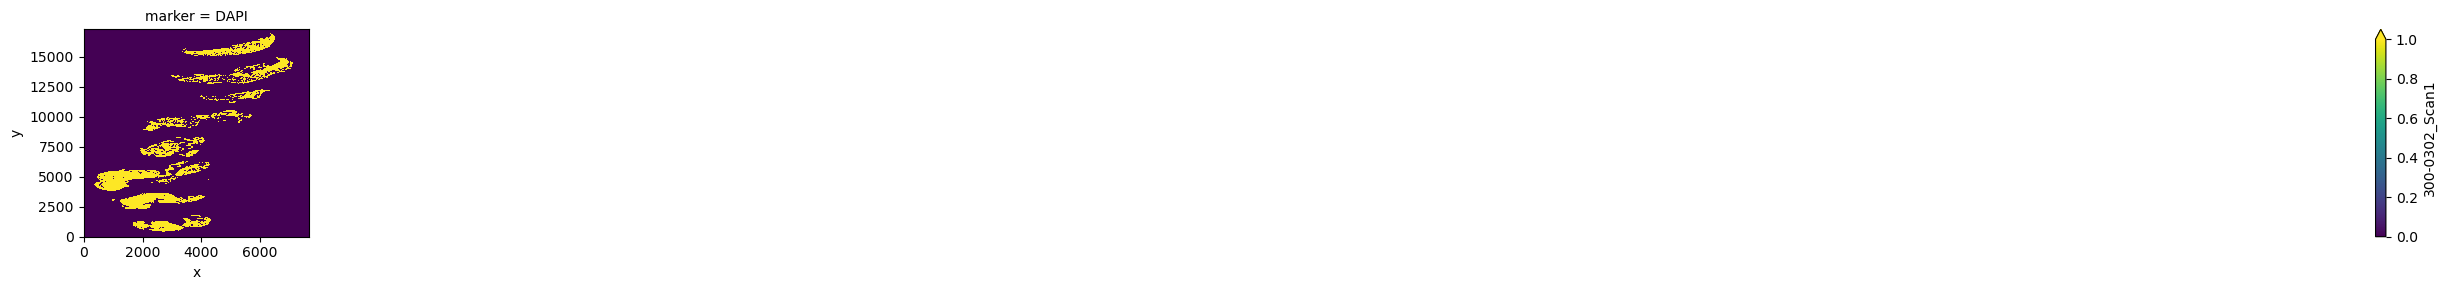

reading 300-0504_Scan1
53897 of 2557440 (2%) pixels are non-empty


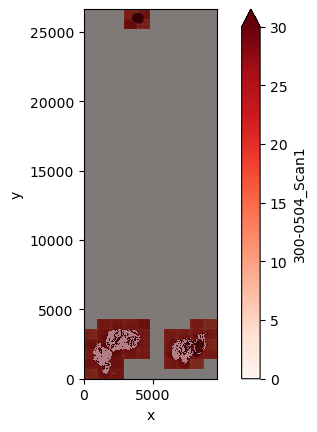

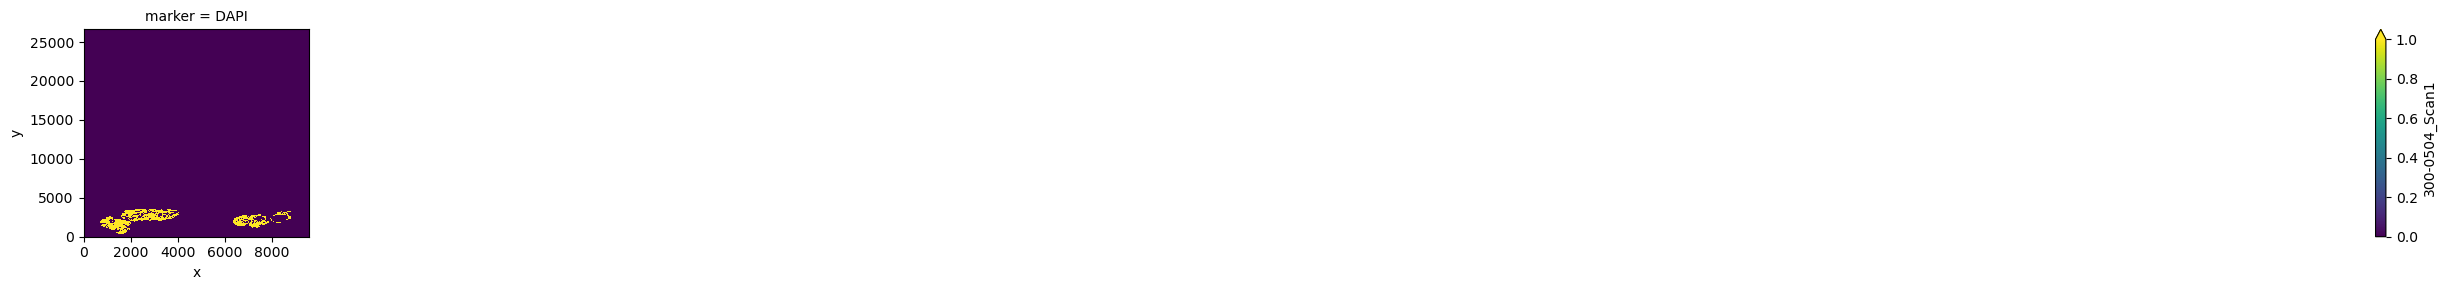

reading 300-0183_Scan1
59133 of 2999808 (2%) pixels are non-empty


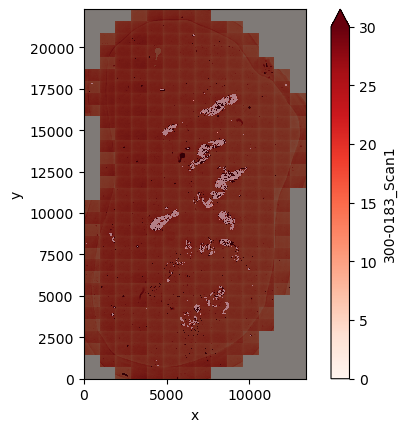

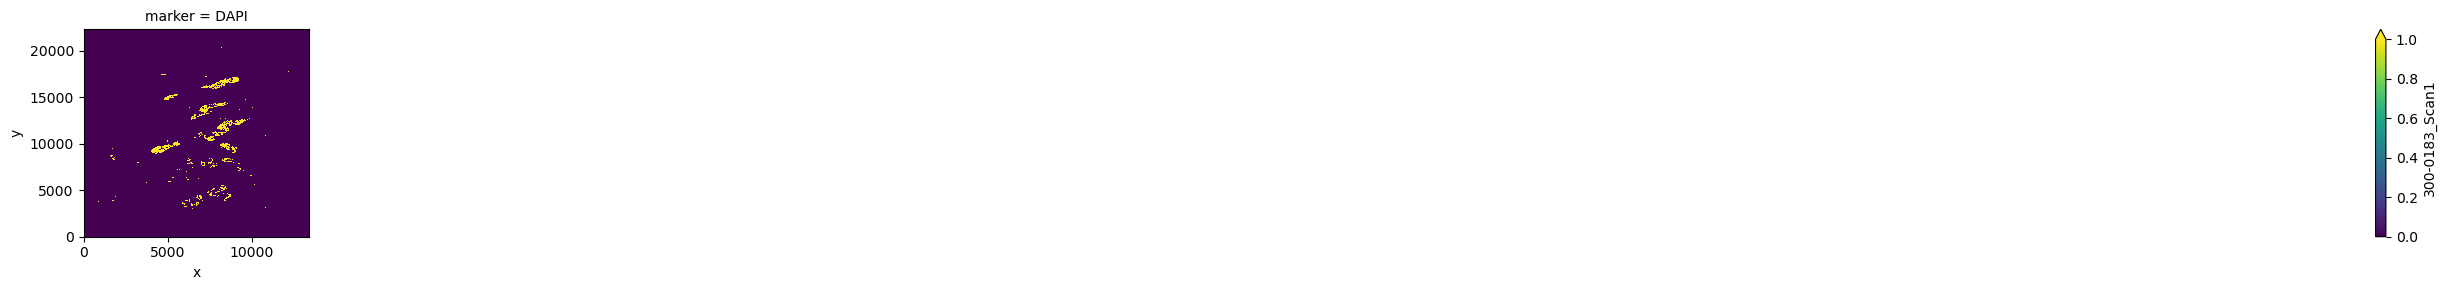

reading 300-0464_Scan1
76744 of 4423680 (2%) pixels are non-empty


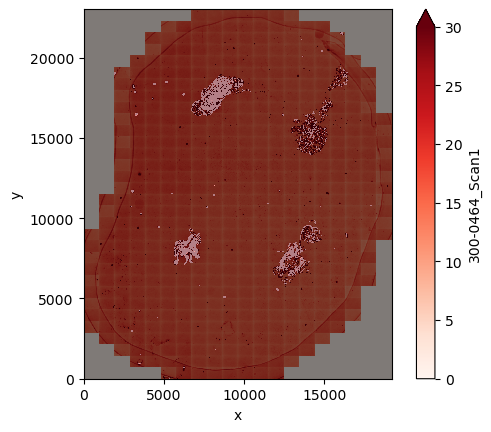

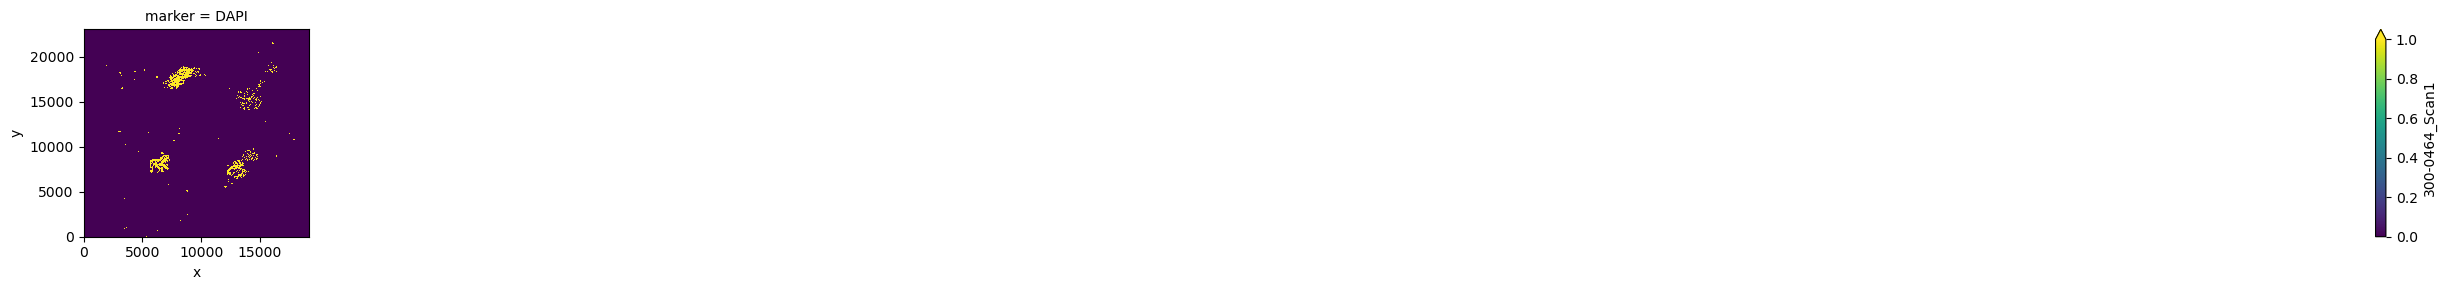

reading 300-0506_Scan1
53758 of 1935360 (3%) pixels are non-empty


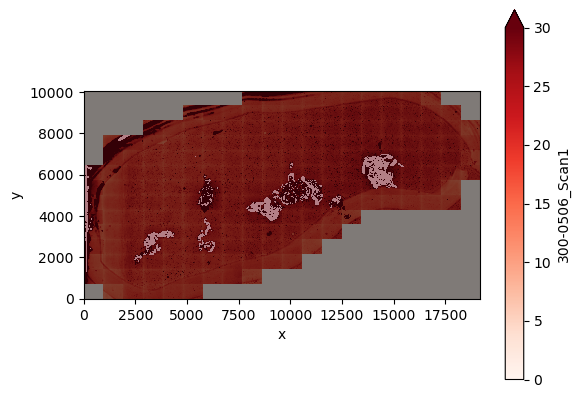

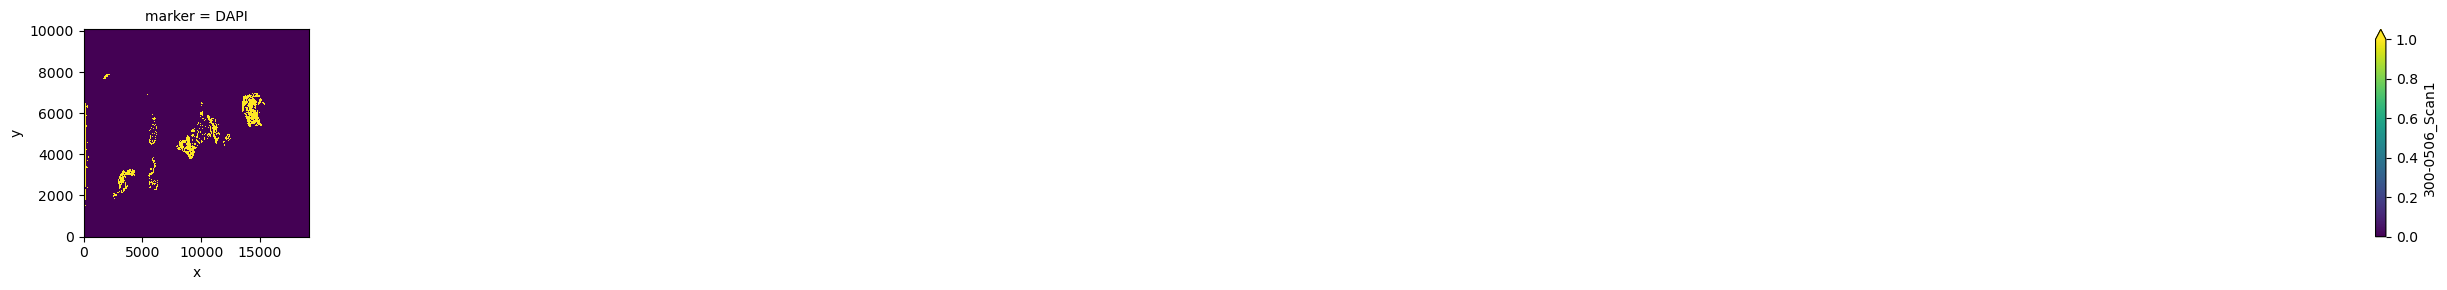

reading 300-0501_Scan1
103212 of 2612736 (4%) pixels are non-empty


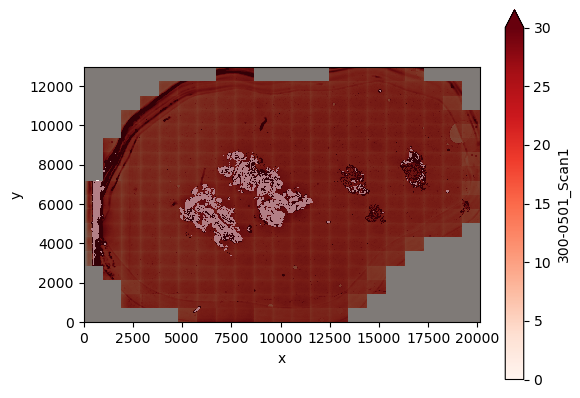

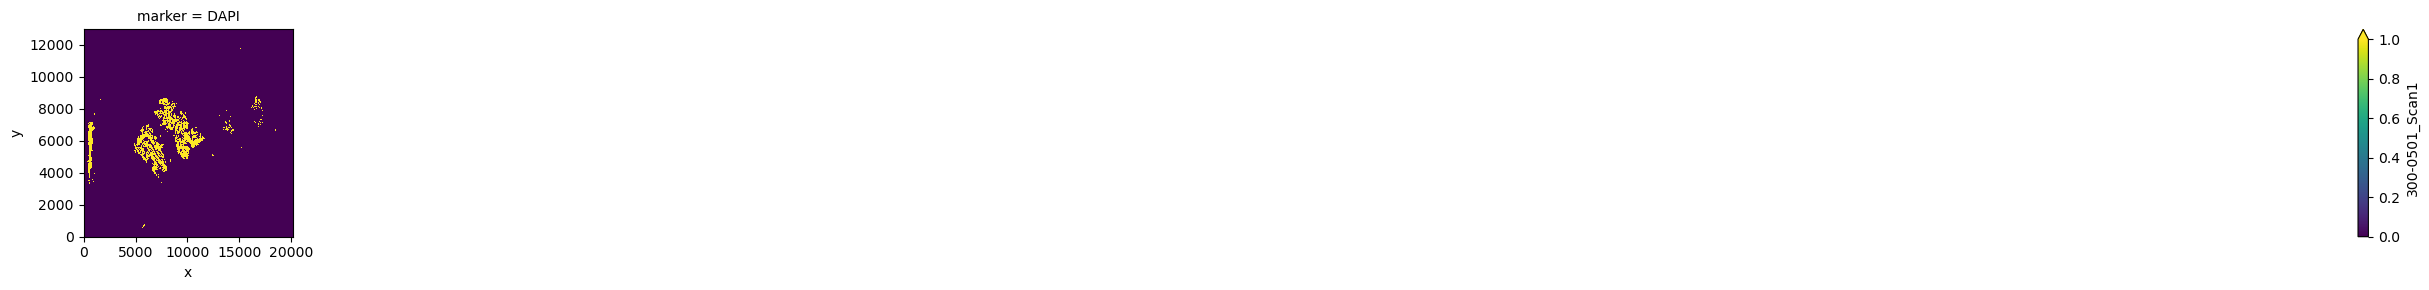

reading 300-0307_Scan1
63780 of 3642624 (2%) pixels are non-empty


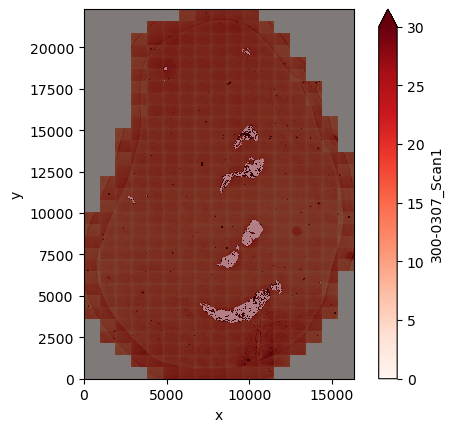

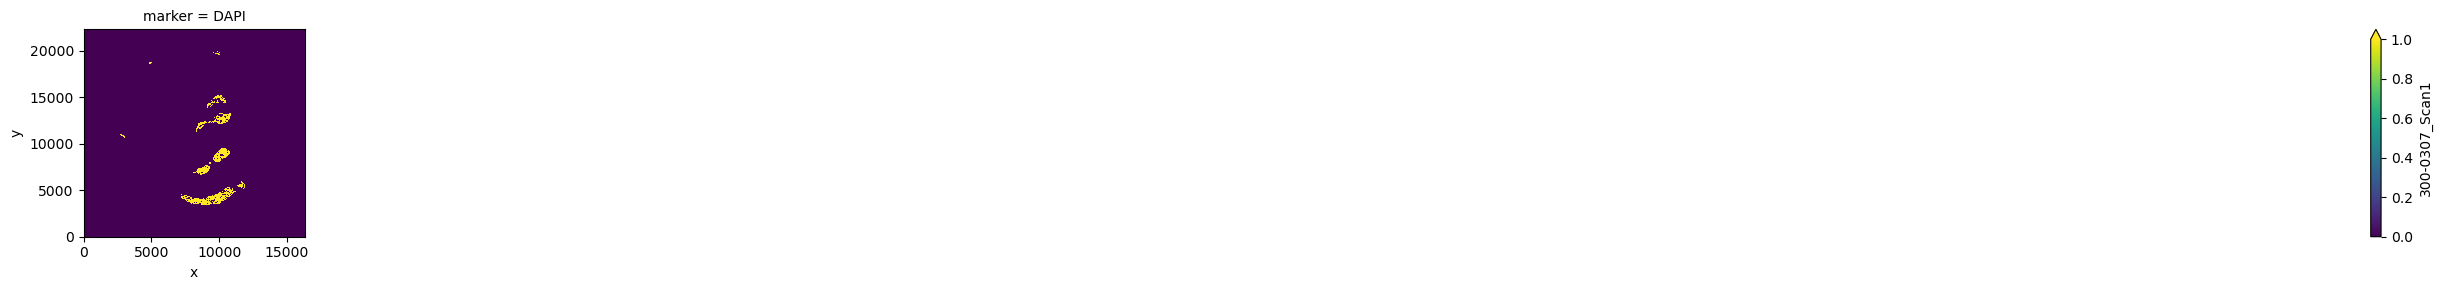

reading 300-0507_Scan1
126999 of 2903040 (4%) pixels are non-empty


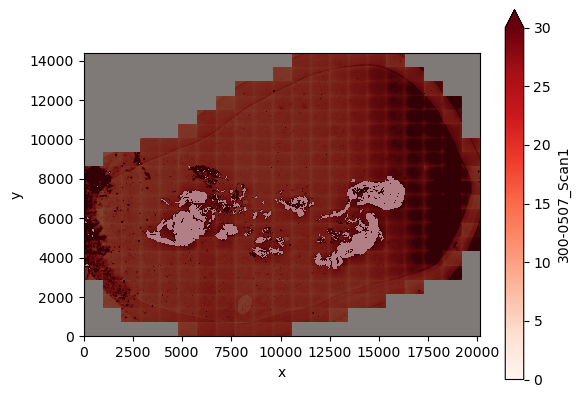

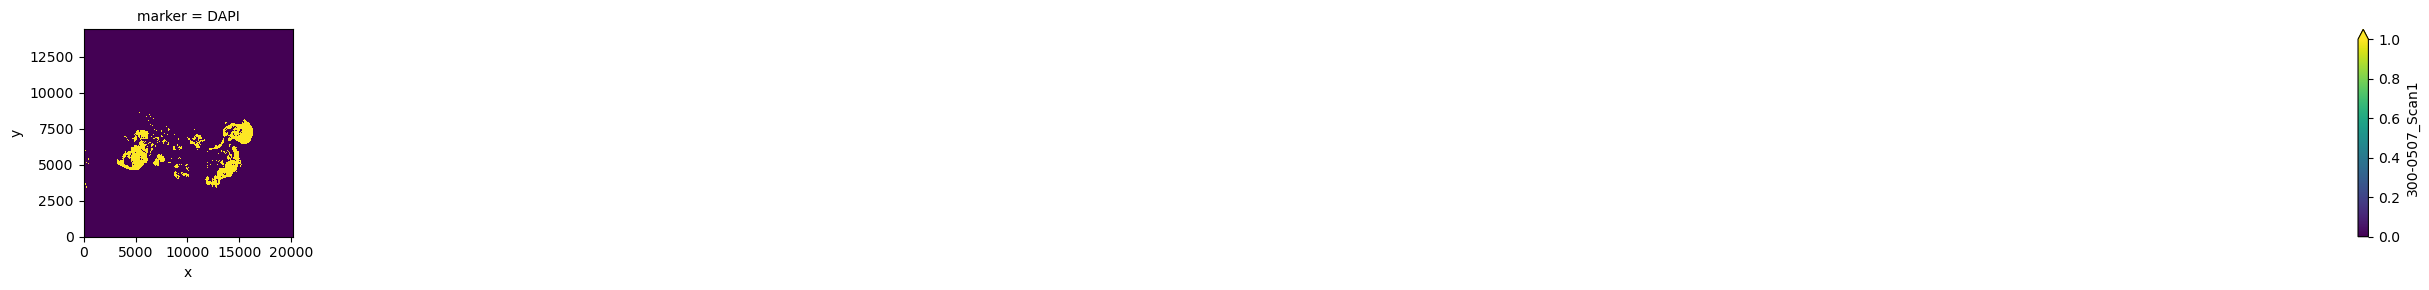

reading 300-0223_Scan1
68510 of 725760 (9%) pixels are non-empty


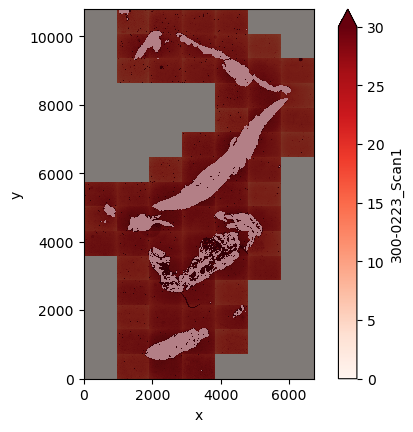

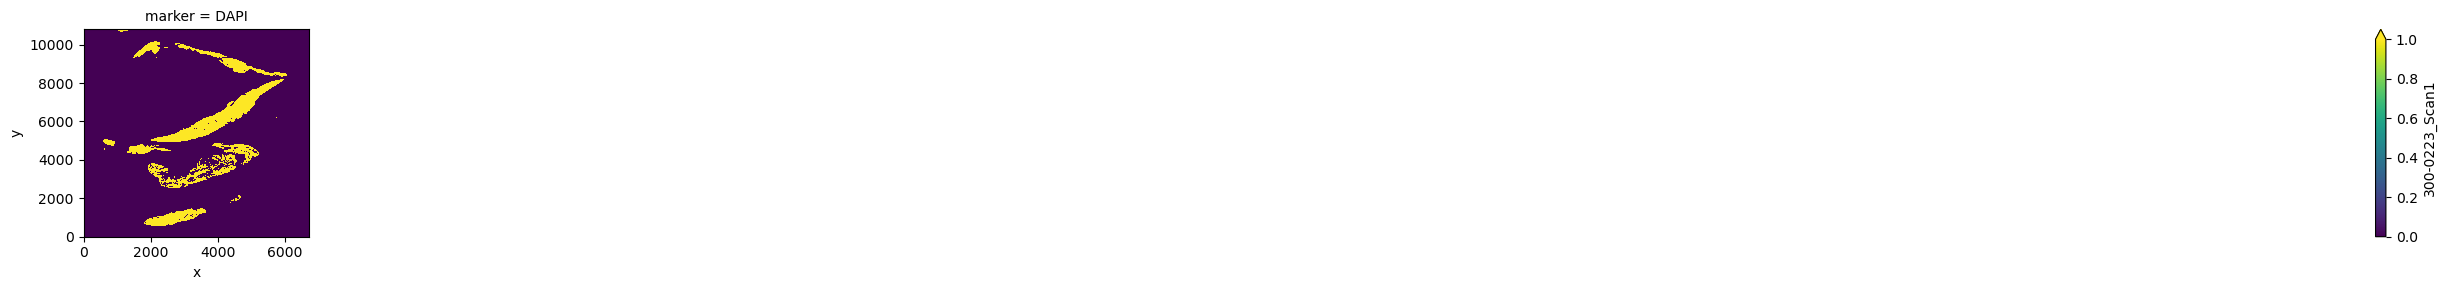

reading 300-0504_Scan2
55718 of 2488320 (2%) pixels are non-empty


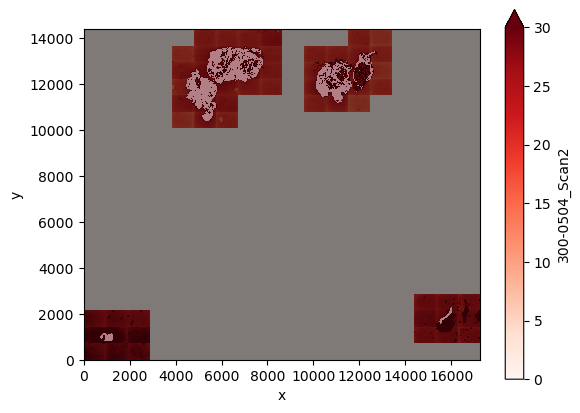

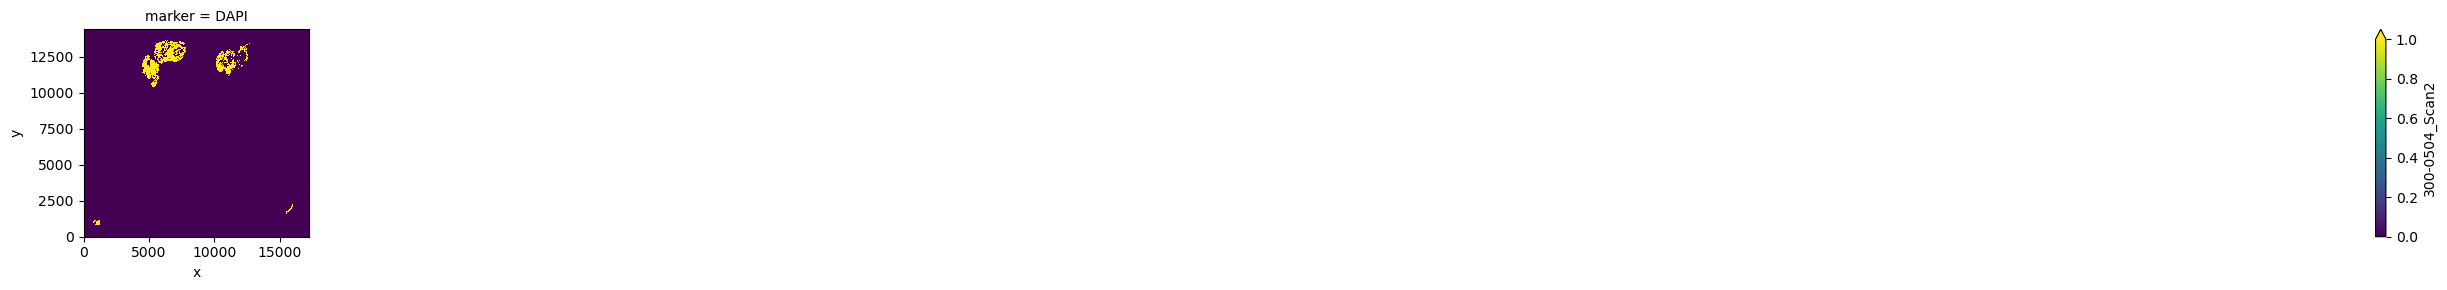

reading 300-0302_Scan2
143560 of 3898368 (4%) pixels are non-empty


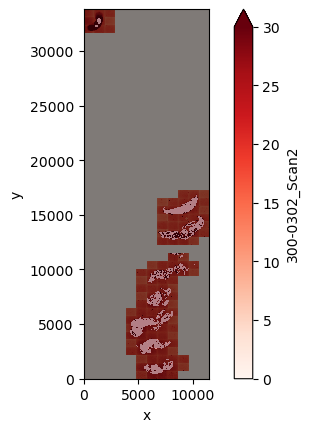

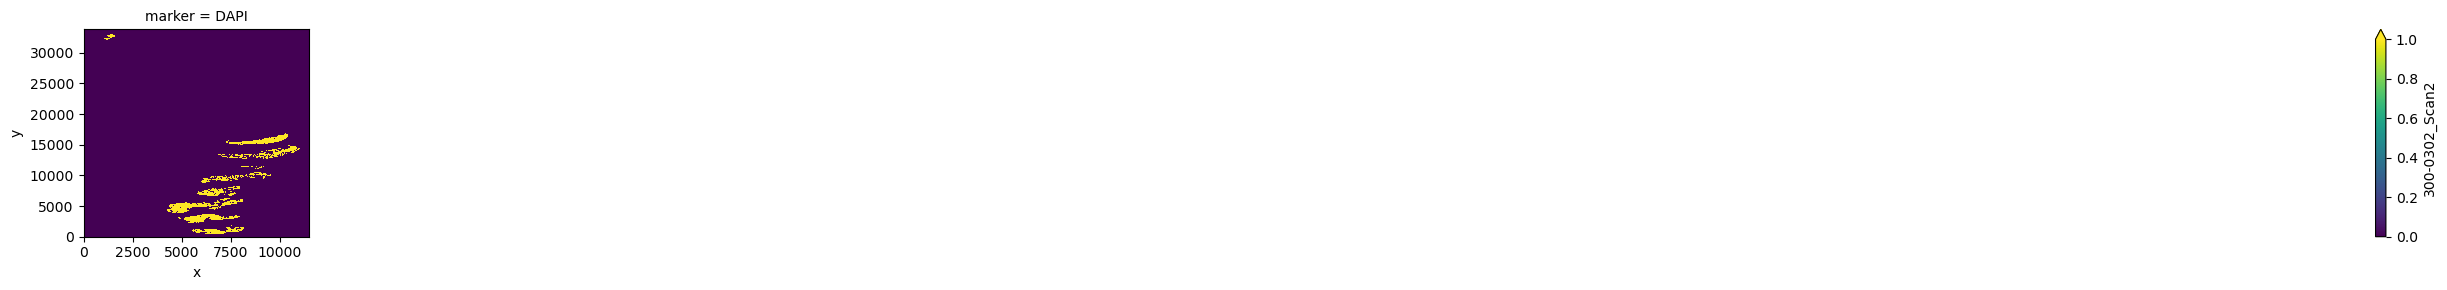

reading 300-1933_Scan2
108619 of 5571072 (2%) pixels are non-empty


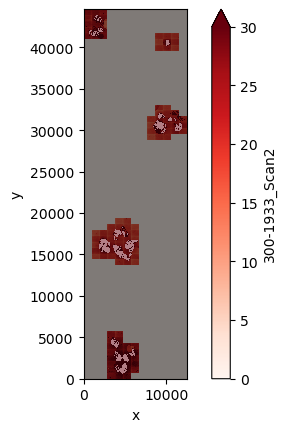

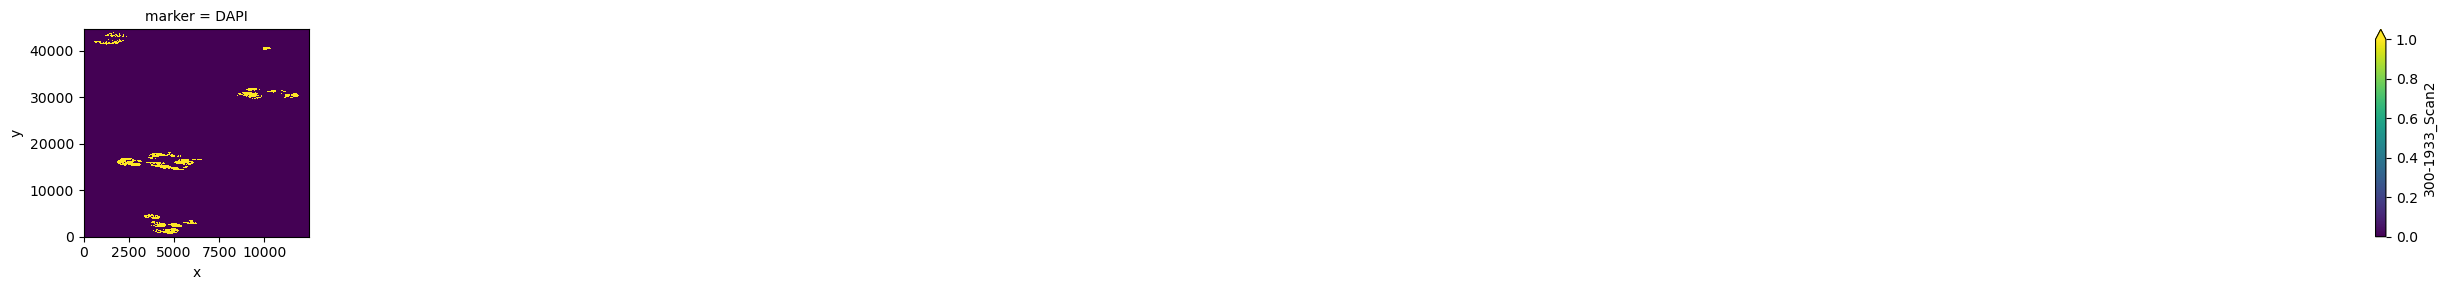

reading 300-0310_Scan2
89873 of 4064256 (2%) pixels are non-empty


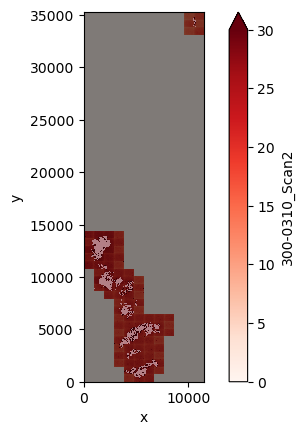

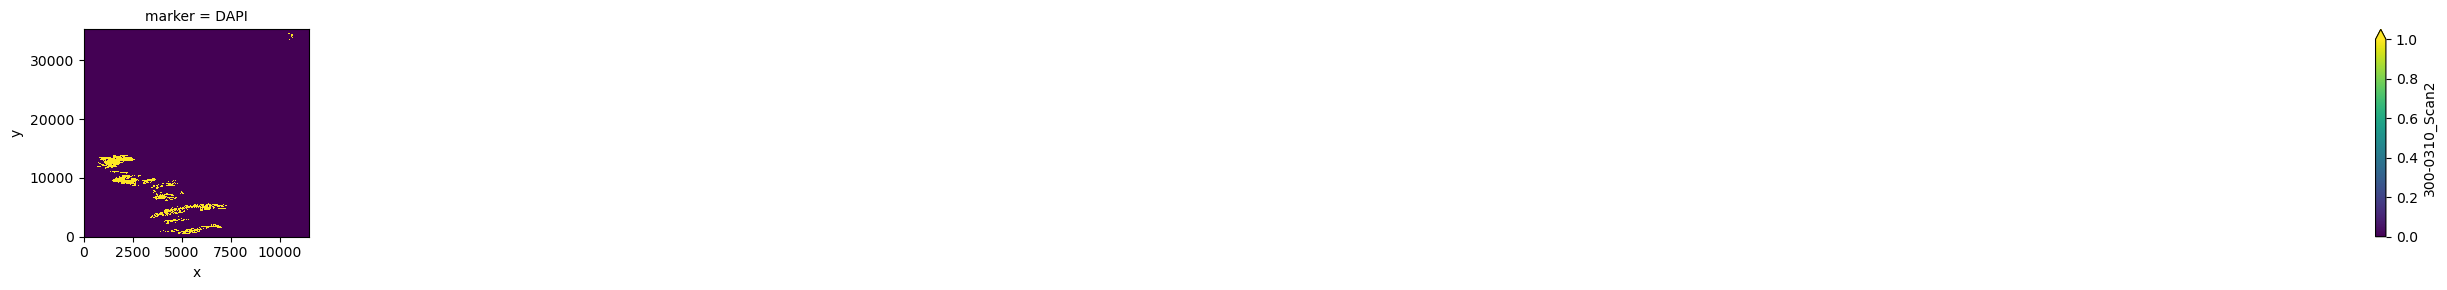

reading 300-0529_Scan1
40333 of 3677184 (1%) pixels are non-empty


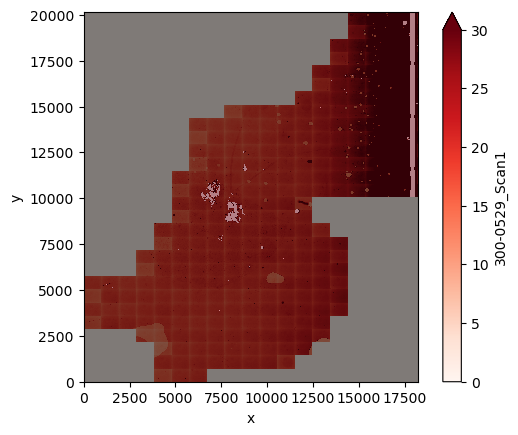

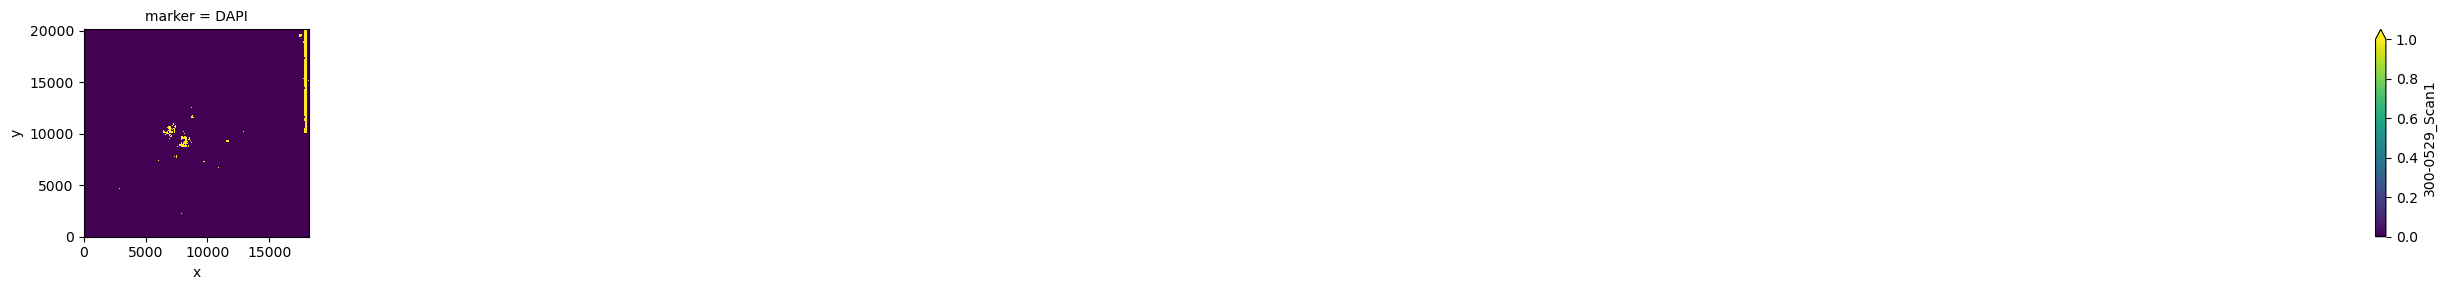

reading 300-2660_Scan1
91086 of 1368576 (7%) pixels are non-empty


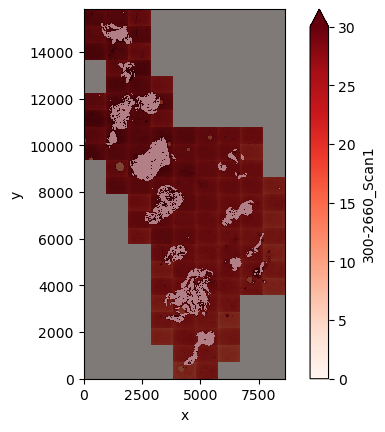

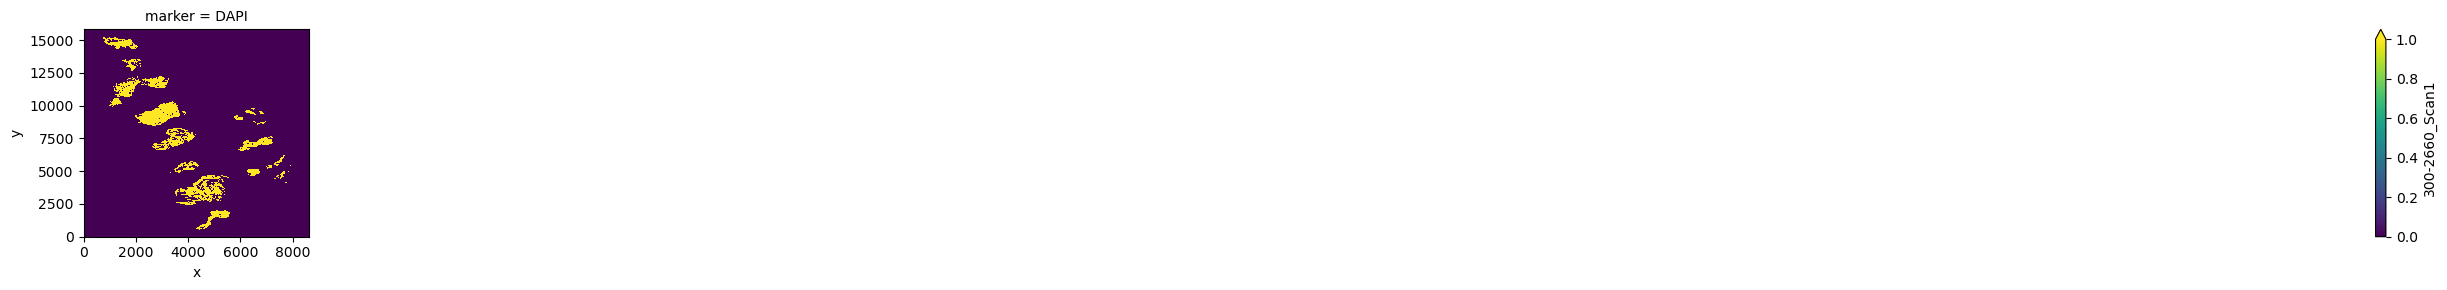

reading 300-0491_Scan1
134791 of 1762560 (8%) pixels are non-empty


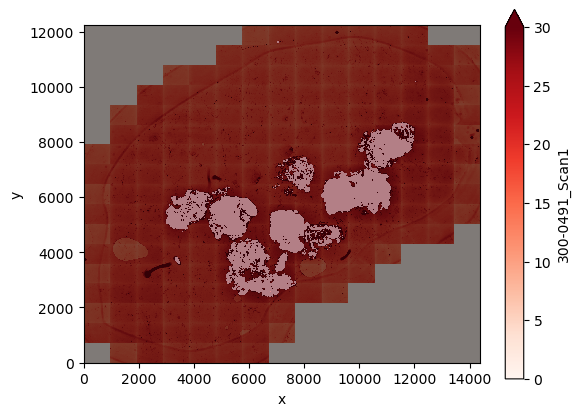

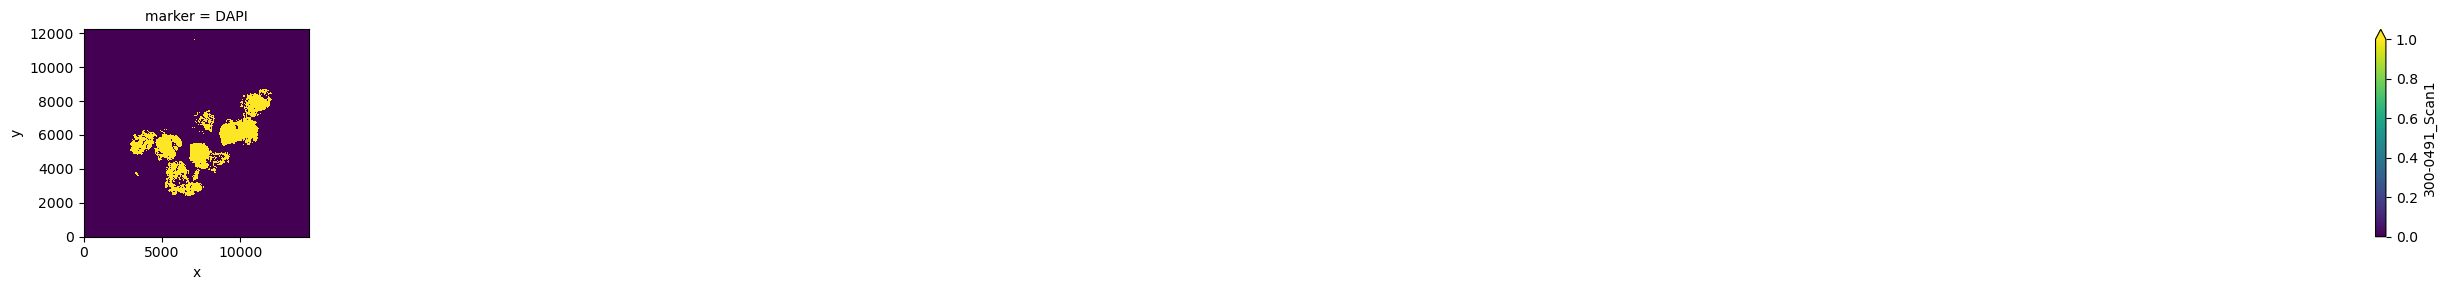

0

In [2]:
real_markers = markers[:-1]
neg_ctrls = markers[-1:]
blur_width = 5
from importlib import reload; reload(ti)

get_foreground = lambda s: ti.foreground_mask_ihc(s, real_markers, neg_ctrls, blur_width=blur_width)
ti.write_masks(downsampledpixelsdir, masksdir, get_foreground, sids)
os.system('say done')

In [2]:
from importlib import reload; reload(ti)
def transform(X):
    return (1+X[:,:-1]) / (1+X[:,-1])[:,None]

def get_sumstats_bham(pixels):
    pixels = transform(pixels)
    ntranscripts = pixels.sum(axis=1, dtype=np.float64)
    med_ntranscripts = np.median(ntranscripts)
    pixels = np.log1p(med_ntranscripts * pixels / ntranscripts[:,None])
    means = pixels.mean(axis=0, dtype=np.float64)
    stds = pixels.std(axis=0, dtype=np.float64)
    return {'means':means, 'stds':stds, 'med_ntranscripts':med_ntranscripts}

def normalize_bham(mask, s, med_ntranscripts=None, means=None, stds=None):
    s = s.where(mask, other=0)
    pl = ti.xr_to_pixellist(s, mask)
    pl = transform(pl)
    pl = np.log1p(med_ntranscripts * pl / pl.sum(axis=1)[:,None])
    pl -= means
    pl /= stds
    s = s.sel(marker=markers[:-1])
    ti.set_pixels(s, mask, pl)
    s.attrs['med_ntranscripts'] = med_ntranscripts
    s.attrs['means'] = means
    s.attrs['stds'] = stds
    return s

ti.normalize_allsamples(downsampledpixelsdir, masksdir, normedpixelsdir, sids,
                               get_sumstats=get_sumstats_bham,
                               normalize=normalize_bham)

reading all non-empty pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.56it/s]


computing sumstats
normalizing and writing


100%|███████████████████████████████████████████████████████████████| 27/27 [00:14<00:00,  1.85it/s]


# reduce to 5 meta-markers using PCA

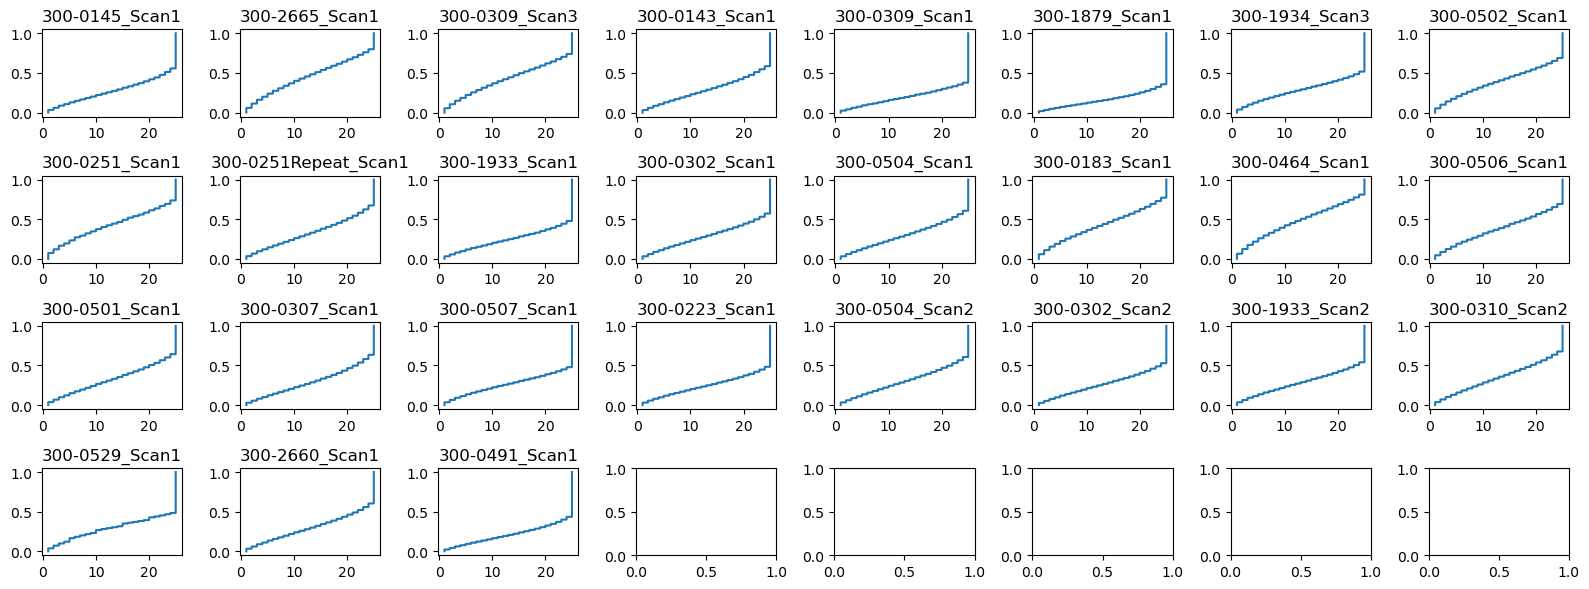

In [3]:
# create metapixels for more accurate PCA
metapixels, npixels = ti.metapixels_allsamples(normedpixelsdir, masksdir, sids)

merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(3014122, 7)
performing PCA


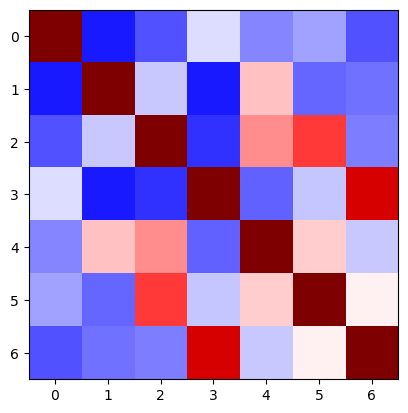

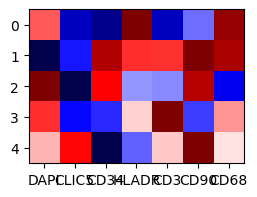

72430

In [4]:
# PCA the metapixels
loadings, C, allmp = ti.pca_metapixels(metapixels.values(), k)
loadings.to_feather(f'{processeddir}/_pcloadings.feather')
del metapixels, allmp; gc.collect()

reading in pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.59it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


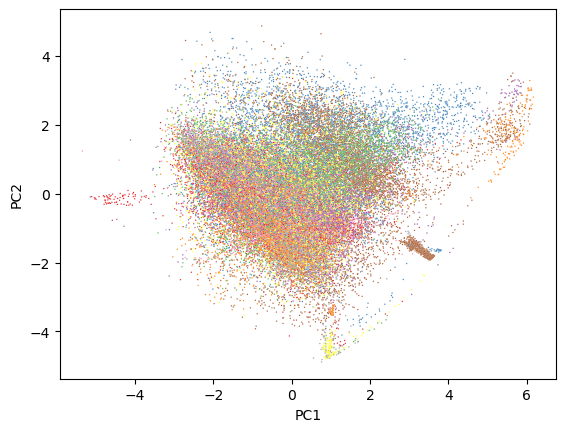

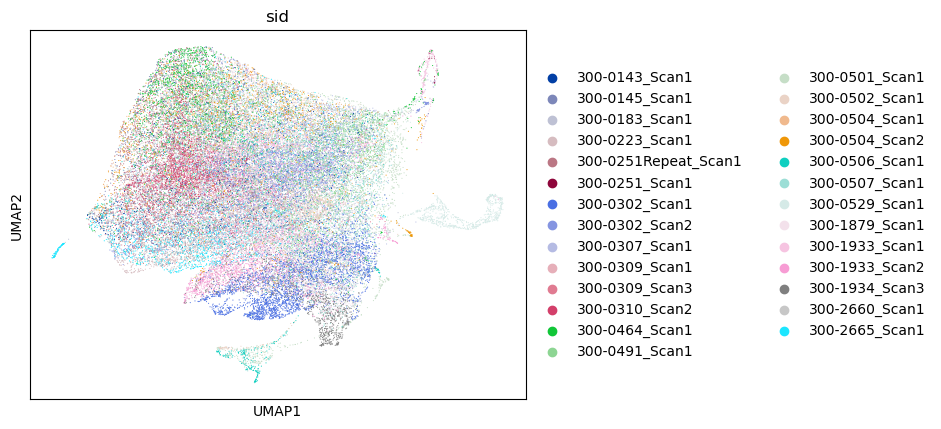

In [5]:
# apply the PC loadings to plain pixels
allpixels_pca = ti.pca_pixels(normedpixelsdir, masksdir,
                              pd.read_feather(f'{processeddir}/_pcloadings.feather'), sids)
allpixels_pca.to_feather(f'{processeddir}/_allpixels_pca.feather')

# Run harmony on PCA'd pixels

In [6]:
# run harmony
allpixels_pca = pd.read_feather(f'{processeddir}/_allpixels_pca.feather')
ti.harmonize(allpixels_pca, processeddir)

Please run the following command in your R environment:
Rscript /Users/yakir/Dropbox/py/tpae/data/harmonize.R /Users/yakir/ST/RA/BHAM-data/10u/pca_k=5_harmony/_allpixels_pca.feather sid


In [ ]:
# read in result and write individual samples
harmpixels = pd.read_feather(f'{processeddir}/_allpixels_pca_harmony.feather')
ti.visualize_pixels(harmpixels, 50000, ['sid'])
ti.write_harmonized(masksdir, processeddir, harmpixels, sids)

# Sanity checks

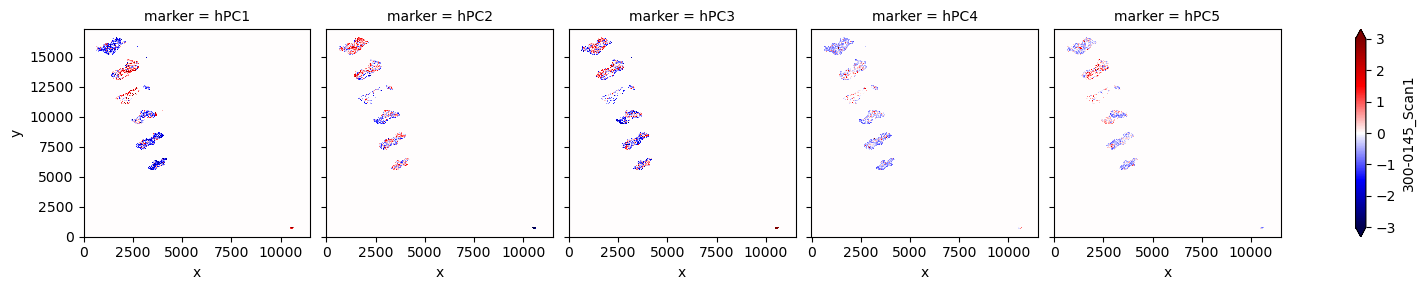

In [8]:
# all pcs of one sample
s = xr.open_dataarray(f'{processeddir}/{sids[0]}.nc').astype(np.float32)
s.plot(col='marker', col_wrap=5, vmin=-3, vmax=3, cmap='seismic')

01234

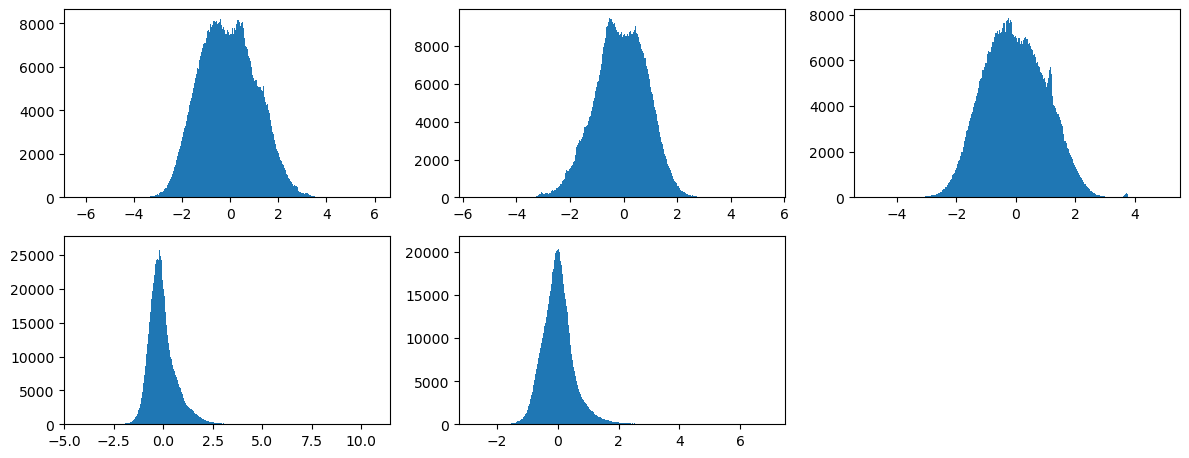

In [9]:
# histogram of each pc
harmpixels = pd.read_feather(f'{processeddir}/_allpixels_pca_harmony.feather')
plt.figure(figsize=(12,9))
for i in range(k):
    print(i, end='')
    plt.subplot(4, 3, i+1)
    plt.hist(harmpixels.values[:,i], bins=1000)
plt.tight_layout()
plt.show()

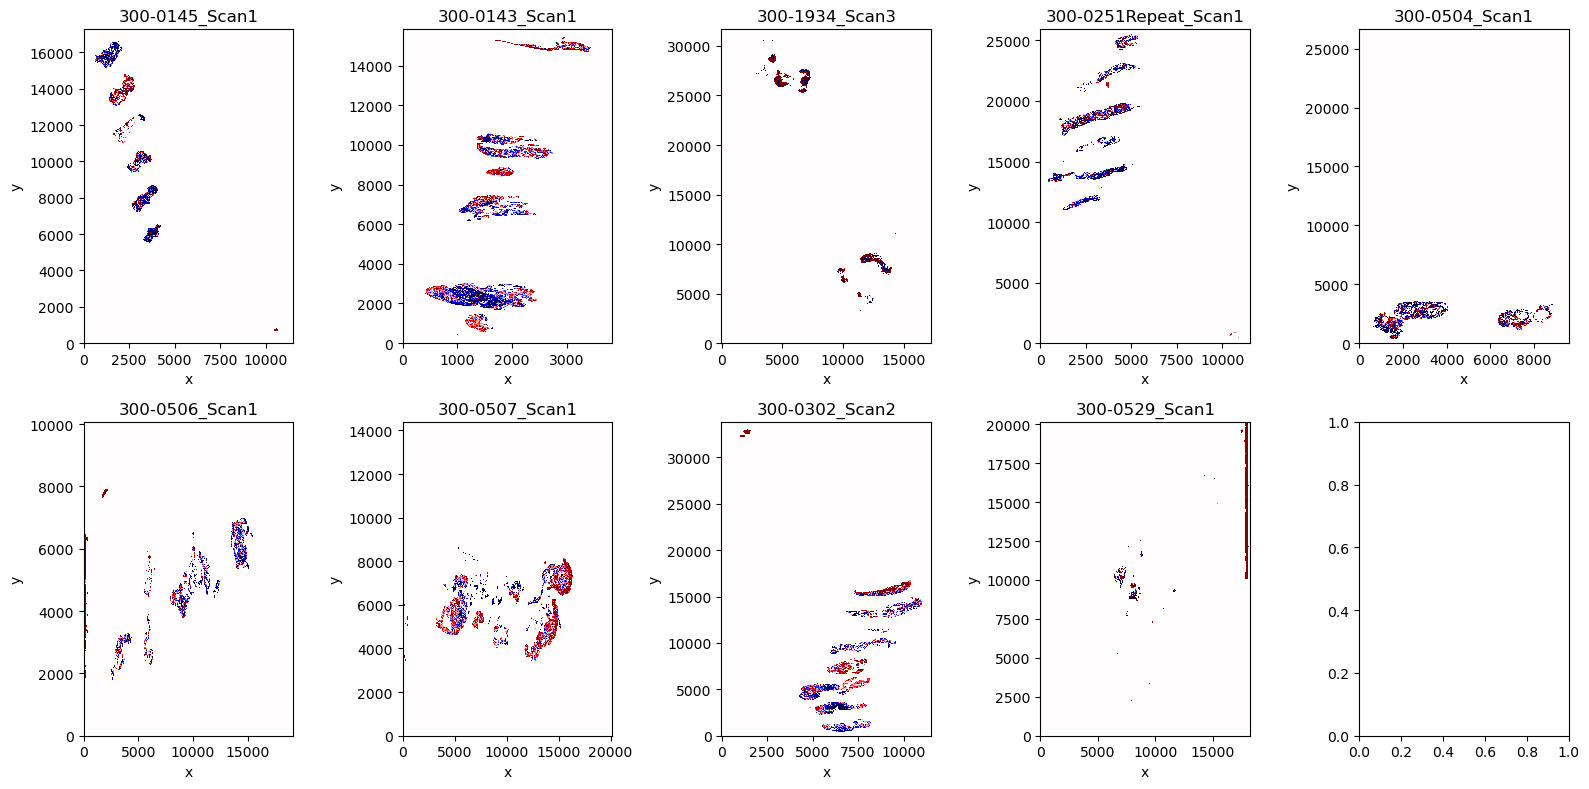

In [10]:
# PC1 of several samples
from IPython.display import display, clear_output
fig, axs = plt.subplots(len(sids[::5])//5 + 1, 5, figsize=(16, 4*(len(sids[::5])//5 + 1)))
for sid, ax in zip(sids[::3], axs.flatten()):
    s = xr.open_dataarray(f'{processeddir}/{sid}.nc').astype(np.float32)
    vmax = np.percentile(np.abs(s.sel(marker='hPC1').data), 99)
    s.sel(marker='hPC1').plot(ax=ax, cmap='seismic', vmin=-vmax, vmax=vmax, add_colorbar=False)
    ax.set_title(sid)
    plt.tight_layout(); clear_output(wait=True); display(fig)
    gc.collect()
plt.close()